In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. Загрузка данных

In [65]:
# загрузка данных из гугл диска
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

zip_path = "/content/drive/My Drive/veg.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content/data")

os.listdir("/content/data") # показать содержимое


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Vegetable Images']

In [66]:
# дата сет
import os

data_path = "/content/data/Vegetable Images"
train_data_dir = "/content/data/Vegetable Images/train"
test_data_dir = "/content/data/Vegetable Images/test"
val_data_dir = "/content/data/Vegetable Images/validation"


# посмотрим содержимое директорий
print(os.listdir(data_path))
print(os.listdir(train_data_dir))
print(os.listdir(test_data_dir))
print(os.listdir(val_data_dir))

['validation', 'test', 'train']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']


In [67]:
# #  скачаем торч
# !pip install torchvision


In [68]:
#  количество объектов в классах

def count_images(directory):

    categories = os.listdir(directory)

    category_count = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return category_count




train_count = count_images(train_data_dir)
test_count = count_images(test_data_dir)
validation_count = count_images(val_data_dir)



print(f"Train sample count : {train_count}\n")
print(f"Test sample count : {test_count}\n")
print(f"Validation sample count : {validation_count}")

Train sample count : {'Carrot': 1000, 'Cauliflower': 1000, 'Bottle_Gourd': 1000, 'Cabbage': 1000, 'Broccoli': 1000, 'Radish': 1000, 'Brinjal': 1000, 'Potato': 1000, 'Tomato': 1000, 'Cucumber': 1000, 'Papaya': 1000, 'Bean': 1000, 'Capsicum': 1000, 'Bitter_Gourd': 1000, 'Pumpkin': 1000}

Test sample count : {'Carrot': 200, 'Cauliflower': 200, 'Bottle_Gourd': 200, 'Cabbage': 200, 'Broccoli': 200, 'Radish': 200, 'Brinjal': 200, 'Potato': 200, 'Tomato': 200, 'Cucumber': 200, 'Papaya': 200, 'Bean': 200, 'Capsicum': 200, 'Bitter_Gourd': 200, 'Pumpkin': 200}

Validation sample count : {'Carrot': 200, 'Cauliflower': 200, 'Bottle_Gourd': 200, 'Cabbage': 200, 'Broccoli': 200, 'Radish': 200, 'Brinjal': 200, 'Potato': 200, 'Tomato': 200, 'Cucumber': 200, 'Papaya': 200, 'Bean': 200, 'Capsicum': 200, 'Bitter_Gourd': 200, 'Pumpkin': 200}


Преобразуем данные к 224х224 пикселя с помощью `transforms.Compose`. Для загрузки данных в предобученную модель (Resnet18), используем `ImageDataLoader`.
Этот класс загружает данные из датасета батчами, используется для итерации по данным во время обучения (каждая итерация соответствует загрузке одного батча данных).

In [69]:
# загрузим библиотеки из торч
import torchvision.datasets as datasets
from torchvision import datasets
from torchvision.datasets import ImageFolder

# Преобразуем данные к 224х224
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])


# Создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)
test_dataset = ImageFolder(test_data_dir, transform=test_transforms)

# Загрузка данных из датасета батчами
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Отобразим случайную выборку из тренировочных данных.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_images(images, num_images=36):
    # Выбор случайных индексов для отображения изображений
    indices = random.sample(range(len(images)), min(num_images, len(images)))

    images = images.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(6, 6, figsize=(10, 10))

    for i in range(num_images):
        ax = axes[i // 6][i % 6] if num_images > i else None

        if ax is not None:
            ax.imshow(images[indices[i]])
            ax.axis('off')

        else:
            break

    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images_batch = next(iter(train_loader))[0]

# Отображение случайных изображений из батча без нормализации цветов
show_random_images(images_batch)




In [71]:
#  набор классов в выборке
train_classes_list = train_dataset.classes
val_classes_list = val_dataset.classes
test_classes_list = test_dataset.classes
print(f"список классов в тренировочной выборке: {train_classes_list}")
print(f"список классов в валидационной выборке: {val_classes_list}")
print(f"список классов в тестовой выборке: {test_classes_list}")


Проверим количество батче в выборках.

In [72]:
len(train_loader), len(val_loader), len(test_loader) # количество батчей в даталодер
print("train", len(train_loader))
print("test", len(test_loader))
print("val", len(val_loader))


# 2. Обучение нейросети на предобученой архитектуре.


## 2.1 Архетектура ResNet18
Загрузим предобученную модель ResNet18 и заменим в ней последний слой так, чтобы на выходе было 15 классов. Gростая архитектура, подходит для задач классификации изображений.

In [ ]:
# загрузим предобученую архитектуру модели ResNet18
model = models.resnet18(pretrained=True)

# Заменим последний слой так, чтобы количество выходных каналов соответствовало 15 классам
num_classes = 15
model.fc = nn.Linear(model.fc.in_features, num_classes)


## 2.2 Обучение сети.
Обучение нейронной сети на тренировочной выборке и на валидационной (проверочной) выборке.
количество эпох выбрано 3.
оптимизатор Adam.


In [ ]:
# обучение сети
from tqdm import tqdm

# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# число эпох
num_epochs = 3

train_data_loss = []
train_data_accuracy = []
val_data_loss = []
val_data_accuracy= []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_data_loss.append(train_loss)
    train_data_accuracy.append(train_accuracy)

    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_data_loss.append(val_loss)
    val_data_accuracy.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

print('Training and validation complete!')

## 2.3 Оценка качества модели

Прогон через тестовую выборку

In [ ]:
import torch
from tqdm import tqdm

# Загрузка модели (если она была сохранена)
model.load_state_dict(torch.load('best_model.pth'))  # Загрузите лучшую модель
model.to(device)  # Переместите модель на устройство (GPU/CPU)

# Переводим модель в режим оценки
model.eval()

# Переменные для подсчета потерь и точности
test_loss = 0.0
correct = 0
total = 0

# Отключаем вычисление градиентов для ускорения и экономии памяти
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Перемещаем данные на устройство (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Прямой проход (forward pass)
        outputs = model(images)

        # Вычисление потерь
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Вычисление точности
        _, predicted = outputs.max(1)  # Получаем предсказанные классы
        total += labels.size(0)  # Общее количество примеров
        correct += predicted.eq(labels).sum().item()  # Количество правильных предсказаний

# Средние потери и точность на тестовых данных
test_loss /= len(test_loader)  # Средние потери
test_accuracy = correct / total  # Точность

# Вывод результатов
print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [62]:
#  оценка качества модели на тестовой выборке

#  матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Сбор предсказаний и истинных меток
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

train_accur = correct / total
val_accur = correct / total
test_accur = correct / total



AttributeError: 'Sequential' object has no attribute 'eval'

In [ ]:
test_accur

Построим графики заивсимости функции потерь и точности от эпох. Они дадут понять, переобучилась ли модель.

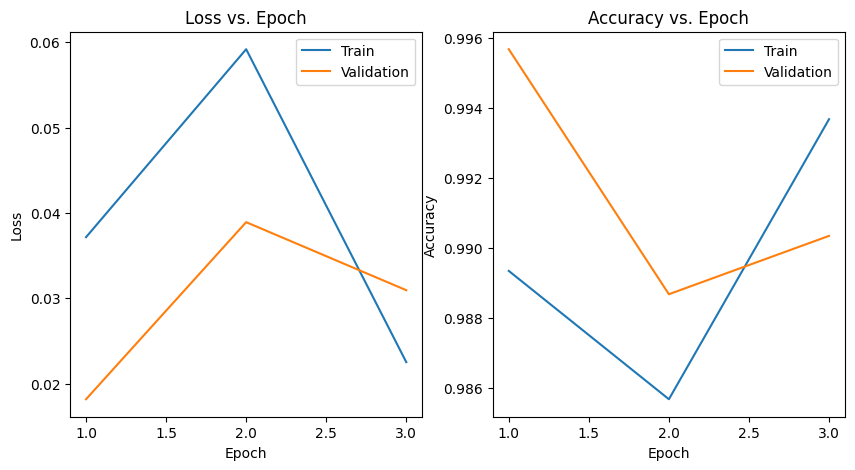

In [18]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_data_loss, label='Train')
plt.plot(range(1, num_epochs+1), val_data_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_data_accuracy, label='Train')
plt.plot(range(1, num_epochs+1), val_data_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

# 3. Создание новой нейронной сети с  нуля.

## 3.1 Преобразование данных.
Так как данные уже загруженны в гугл колаб, то просто загрзим их. Для новой нейросети с нуля я решила использовать библиотеку `TensorFlow`, модуль `Keras`. С помощью `ImageDataGenetaror` преобразуем  значения пикселей изображений к диапазону от 0 до 1.

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Создание генератора данных для тренировочной выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: tf.image.resize(x, (224, 224)))

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Создание генератора данных для валидационной выборки
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [31]:
classes = train_generator.class_indices
classes

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

## 3.2 Создание модели

Для создания новой нейросети, воспользуемся информацией на официальном сайте TesorFlow [последовательная модель Sequential ](https://www.tensorflow.org/guide/keras/sequential_model?hl=ru). Последовательная модель `Sequential` состоит из стека слоев, где каждый слой имеет ровно один тензор входной и один выходной тензор.

In [36]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Первый скрытый слой 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 фильтра
    layers.MaxPooling2D((2, 2)),

    # Второй скрытый слой 2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64 фильтра
    layers.MaxPooling2D((2, 2)),

    # Выравнивание данных для полносвязных слоев
    layers.Flatten(),

    # Выходной слой
    layers.Dense(num_classes, activation='softmax')  # Выходной слой
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │       2,799,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,818,767 (10.75 MB)

 Trainable params: 2,818,767 (10.75 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 Обучение с помощью метода `model.fit()`

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - accuracy: 0.5567 - loss: 1.7006 - val_accuracy: 0.8710 - val_loss: 0.4208
Epoch 2/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.8750 - loss: 0.3495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8750 - loss: 0.3495 - val_accuracy: 0.8760 - val_loss: 0.4112
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.9221 - loss: 0.2695 - val_accuracy: 0.8868 - val_loss: 0.3812
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8750 - loss: 0.2516 - val_accuracy: 0.8844 - val_loss: 0.3892
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.9726 - loss: 0.0987 - val_accuracy: 0.8763 - val_loss: 0.4006


In [39]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8755 - loss: 0.3995
Validation Accuracy: 0.88


После визуализируем данные с помощью графиков. Будут показаны точность модели на тренировочной и валидационной выборках, а также функция потерь на тех же выборках.

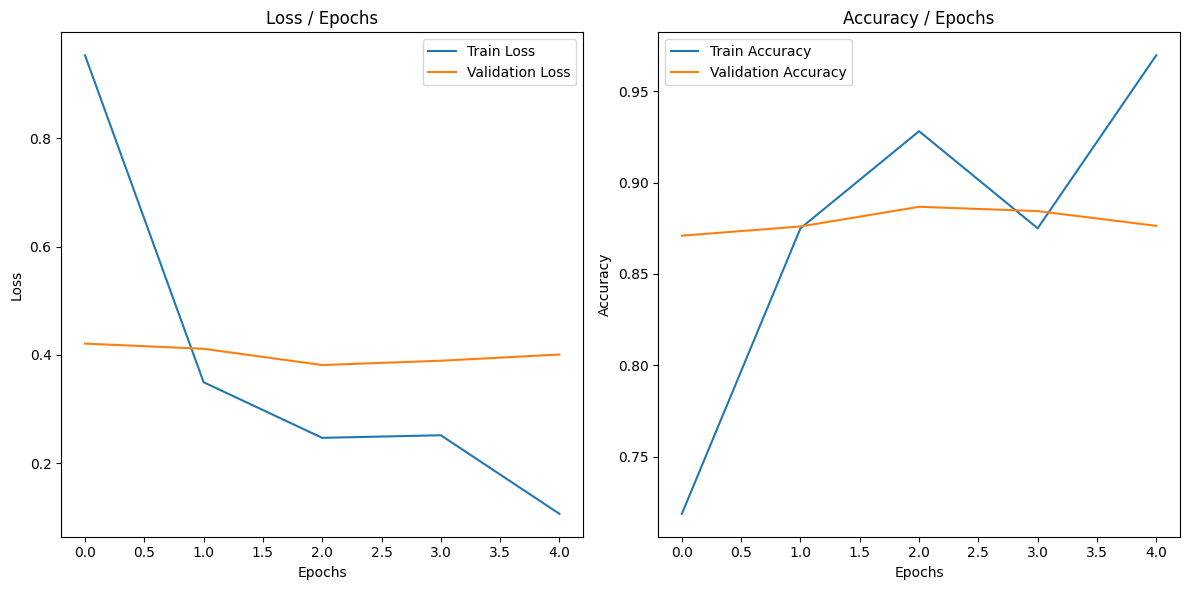

In [49]:
import matplotlib.pyplot as plt

# Извлечение данных из history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# # Оценка модели на тестовых данных
# test_loss, test_accuracy = model.evaluate(test_gen)
# print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

# График функции потерь (Loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

По графикам моэно сделать вывод что модель переобучилась. Есть несколько решений: лоабвить аугментацию, dropout.
Я добавлю в скрытый слой dropout.


In [58]:
from tensorflow.keras import layers, models

model_2 = models.Sequential([
    # Первый скрытый слой 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 фильтра
    layers.MaxPooling2D((2, 2)),

    # Второй скрытый слой 2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64 фильтра
    layers.MaxPooling2D((2, 2)),

    # Выравнивание данных для полносвязных слоев
    layers.Flatten(),

    # Выходной слой
    layers.Dropout(0.2),  # Dropout с вероятностью 50%
    layers.Dense(num_classes, activation='softmax')  # Выходной слой
])

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 15)                  │       2,799,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,818,767 (10.75 MB)

 Trainable params: 2,818,767 (10.75 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 74s 158ms/step - accuracy: 0.9812 - loss: 0.0595 - val_accuracy: 0.9173 - val_loss: 0.3395
Epoch 2/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9688 - loss: 0.0966

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9688 - loss: 0.0966 - val_accuracy: 0.9207 - val_loss: 0.3207
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 69s 141ms/step - accuracy: 0.9853 - loss: 0.0497 - val_accuracy: 0.8975 - val_loss: 0.4127
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 0.8921 - val_loss: 0.4508
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - accuracy: 0.9931 - loss: 0.0273 - val_accuracy: 0.9106 - val_loss: 0.4022


Далее я визуализировала данные уже с примененным `Dropout`.

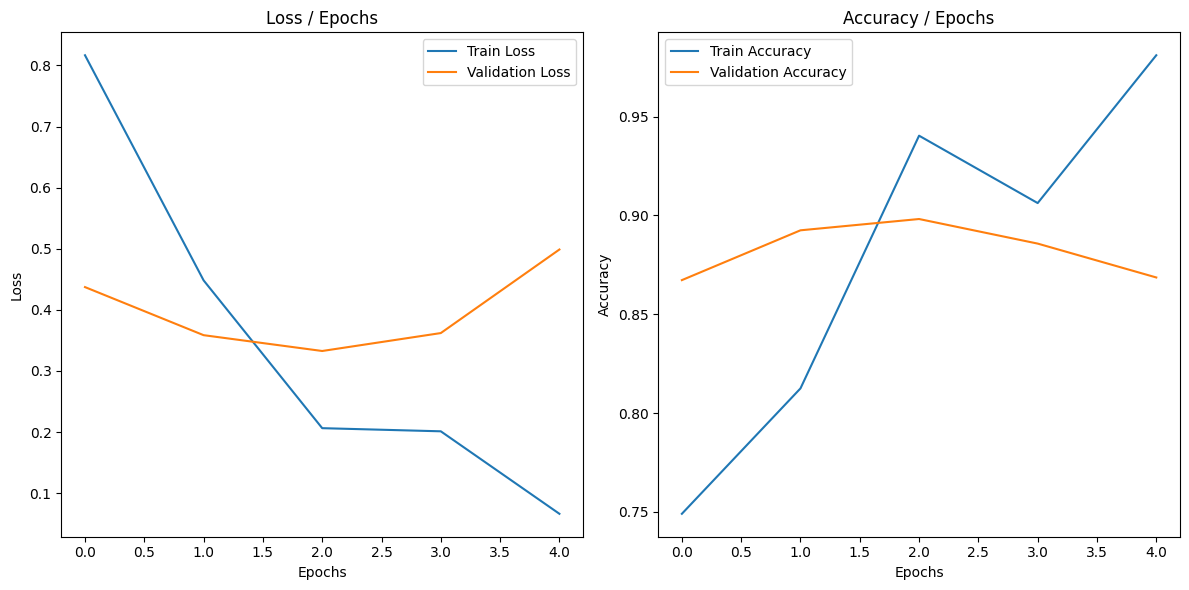

In [60]:
import matplotlib.pyplot as plt

# Извлечение данных из history
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

train_accuracy_2 = history_2.history['accuracy']
val_accuracy_2 = history_2.history['val_accuracy']

# График функции потерь (Loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_2, label='Train Loss')
plt.plot(val_loss_2, label='Validation Loss')
# plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_2, label='Train Accuracy')
plt.plot(val_accuracy_2, label='Validation Accuracy')
# plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 3.4 Проверка на тестовой выборке.
Сначала преобразуем тестовые данные для оценки.

In [45]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_gen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3000 images belonging to 15 classes.


Далее используем `evaluate()` используется для оценки модели тестовых данных (которые не показывались модели). В ответе мы получим значение точности `accuracy` и функции потерь `loss`.

In [40]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'\nTest Loss: {test_loss : .3f}, Test Accuracy: {test_accuracy : .3f}')

 1/94 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8438 - loss: 0.3994

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8907 - loss: 0.3564

Test Loss:  0.386, Test Accuracy:  0.886


График на тестовой выборке отображается как константа, так как при обучении модели тестовые данные не используются. Также на графике на тренировочной выборке, что модель как будто бы переобучилась. Можем добавить Dropout.

Значения точности 88,6 % гвоорят о хорошем обучении модели.

In [55]:
import numpy as np
y_pred_test = model.predict(test_gen) #  получает вероятности классов для тестовых данных

y_pred_class_test = np.argmax(y_pred_test, axis=1) # предсказанные метки классов

y_true_class_test = test_gen.classes # истинные метки классов

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix
matrix = confusion_matrix(y_true_class_test, y_pred_class_test)

report = classification_report(y_true_class_test, y_pred_class_test, target_names=validation_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

NameError: name 'y_true_class_test' is not defined

# Матрица ошибок
 это таблица, которая показывает, как часто модель правильно или ошибочно классифицирует объекты каждого класса. Она позволяет:

Увидеть, какие классы модель путает между собой.

Оценить точность модели для каждого класса.
Строки матрицы соответствуют истинным классам

Столбцы матрицы соответствуют предсказанным классам

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Test_generator.class_indices.keys(),
            yticklabels=Test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_true_classes' is not defined